In [1]:
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import xgboost as xgb
from scipy import interp

from collections import Counter
from sklearn import metrics, preprocessing, linear_model
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_score, recall_score,
    f1_score, accuracy_score, classification_report
)
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, StratifiedKFold
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Drop the 'Time' column from the DataFrame
df = df.drop("Time", axis=1)
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Assign the 'Class' column as the target variable y
y = df["Class"]

# Create the feature matrix X by dropping the 'Class' column
X = df.drop("Class", axis=1)

# Print the shapes of y and X
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)


Shape of y: (284807,)
Shape of X: (284807, 29)


In [5]:
# Splitting the data into 80:20 train test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (227845, 29)
Shape of X_test: (56962, 29)
Shape of y_train: (227845,)
Shape of y_test: (56962,)


In [6]:
print("Fraudulent Count for Full data:", np.sum(y))
print("Fraudulent Count for Train data:", np.sum(y_train))
print("Fraudulent Count for Test data:", np.sum(y_test))


Fraudulent Count for Full data: 492
Fraudulent Count for Train data: 394
Fraudulent Count for Test data: 98


In [7]:
X_test_saved = X_test.copy()
y_test_saved = y_test.copy()
print("Testing set saved for evaluation.")


Testing set saved for evaluation.


In [8]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Scaling the "Amount" feature in the training data
X_train[["Amount"]] = scaler.fit_transform(X_train[["Amount"]])

# Scaling the "Amount" feature in the test data
X_test[["Amount"]] = scaler.transform(X_test[["Amount"]])

# Calculate skewness of features
var = X_train.columns
skewness_list = []
for col in var:
    skewness_list.append(X_train[col].skew())

# Create a DataFrame to store skewness values
skewness_df = pd.DataFrame({"Features": var, "Skewness": skewness_list})
skewness_df.set_index("Features", inplace=True)
skewness_df

# Identify skewed features
skewed_features = skewness_df[(skewness_df["Skewness"] > 1) | (skewness_df["Skewness"] < -1)].index
skewed_features.tolist()

# Importing the required library
from sklearn import preprocessing

# Instantiate the PowerTransformer
pt = preprocessing.PowerTransformer(method='yeo-johnson', copy=True)

# Fit and transform the training data
X_train_pt = pt.fit_transform(X_train)
y_train_pt = y_train

# Transform the test data using the same transformer
X_test_pt = pt.transform(X_test)
y_test_pt = y_test


In [9]:
# Display the power-transformed features
print(X_train_pt)


[[ 1.33618788 -0.54484524 -0.96560586 ...  0.18226012 -0.09086395
  -0.84312016]
 [ 1.42577426 -0.11673724 -1.77657609 ... -0.00550109 -0.20559691
  -1.07812706]
 [-0.75438698  0.33048345  0.39988107 ...  0.08314307  0.57984412
   1.43122753]
 ...
 [ 0.52096648 -0.03765332  0.22167732 ...  0.06556876  0.08664086
   0.39825955]
 [ 0.70400402  0.11684072  0.09210173 ... -0.1603766  -0.00883583
  -1.20086971]
 [-0.57696779  0.45583121  1.4321219  ...  0.94608931  0.64393801
  -0.86019457]]


In [10]:
# Conducting cross-validation for both X_train and y_train datasets.
# Initialize a StratifiedKFold cross-validator for performing cross-validation.

num_splits = 3
random_state = None
shuffle_data = False  # The shuffling of data is disabled by setting shuffle to False in order to maintain consistent results during cross-validation.

skf = StratifiedKFold(n_splits=num_splits, random_state=random_state, shuffle=shuffle_data)


----------------------------------------------------------------------------------------
Starting KNN Classifier...
Currently processing K = 3...
Training indices: [ 75936  75937  75938 ... 227842 227843 227844], Validation indices: [    0     1     2 ... 83545 84117 84974]
Time taken for this iteration: 56.83 seconds
Training indices: [     0      1      2 ... 227842 227843 227844], Validation indices: [ 75936  75937  75938 ... 153006 153116 153683]
Time taken for this iteration: 55.37 seconds
Training indices: [     0      1      2 ... 153006 153116 153683], Validation indices: [151894 151895 151896 ... 227842 227843 227844]
Time taken for this iteration: 56.58 seconds
Avg. ROC-AUC for training data: 0.9999
Avg. ROC-AUC for validation data: 0.9111
----------------------------------------------------------------------------------------
Currently processing K = 5...
Training indices: [ 75936  75937  75938 ... 227842 227843 227844], Validation indices: [    0     1     2 ... 83545 84117

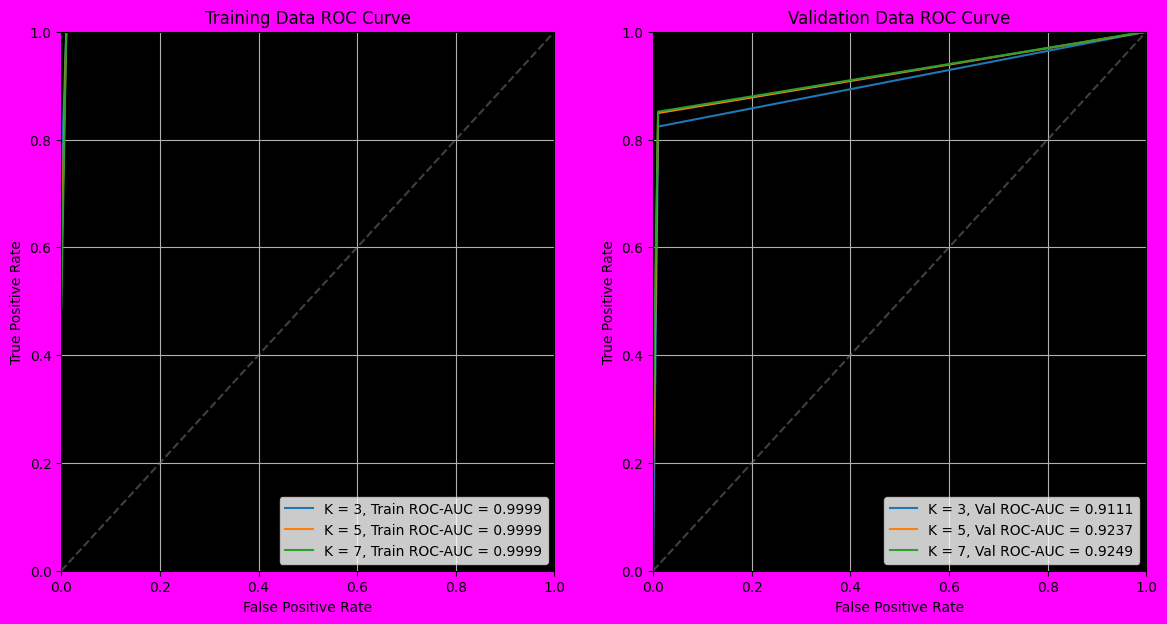

----------------------------------------------------------------------------------------
Plotting ROC-AUC vs. K values...


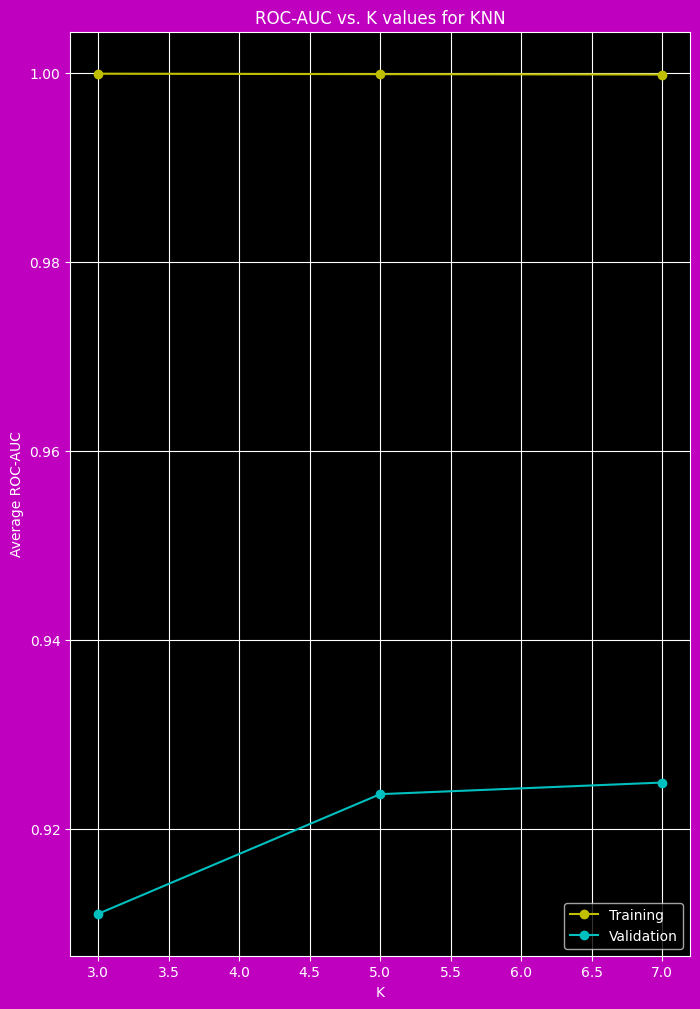

----------------------------------------------------------------------------------------
Summary of Results:
ROC-AUC scores for training with various K: [0.9999479085933528, 0.9999030150193778, 0.9998607640754523]
ROC-AUC scores for validation with various K: [0.9110686212594891, 0.9237188714312442, 0.9249482980359366]
Optimal K value: 7
Best ROC-AUC for validation data: 0.9249
----------------------------------------------------------------------------------------


In [11]:
print("----------------------------------------------------------------------------------------")
print("Starting KNN Classifier...")
K_values = [3, 5, 7]  # Specify the K values to explore

# To collect the average ROC-AUC scores and average false positive rates
mean_roc_auc_scores_train = []
mean_roc_auc_scores_val = []
mean_fpr = np.linspace(0, 1, 100)

# Set up subplots for ROC plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), facecolor='fuchsia')
ax1.set_facecolor('black')
ax2.set_facecolor('black')

# Iterate over different K values
for k in K_values:
    print(f"Currently processing K = {k}...")
    cv_scores_train = []
    cv_scores_val = []
    fprs_train = []
    tprs_train = []
    fprs_val = []
    tprs_val = []

    # Cross-validation step
    for train_index, val_index in skf.split(X_train_pt, y_train_pt):
        start_time = time.time()
        print(f"Training indices: {train_index}, Validation indices: {val_index}")
        X_train_cv, X_val_cv = X_train_pt[train_index], X_train_pt[val_index]
        y_train_cv, y_val_cv = y_train_pt.iloc[train_index], y_train_pt.iloc[val_index]

        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(X_train_cv, y_train_cv)

        y_train_pred = knn_classifier.predict_proba(X_train_cv)
        train_score = roc_auc_score(y_train_cv, y_train_pred[:, 1])
        cv_scores_train.append(train_score)

        y_val_pred = knn_classifier.predict_proba(X_val_cv)
        val_score = roc_auc_score(y_val_cv, y_val_pred[:, 1])
        cv_scores_val.append(val_score)

        fpr_train, tpr_train, _ = roc_curve(y_train_cv, y_train_pred[:, 1])
        tprs_train.append(interp(mean_fpr, fpr_train, tpr_train))

        fpr_val, tpr_val, _ = roc_curve(y_val_cv, y_val_pred[:, 1])
        tprs_val.append(interp(mean_fpr, fpr_val, tpr_val))

        print(f"Time taken for this iteration: {time.time() - start_time:.2f} seconds")

    # Calculating averages
    avg_roc_auc_train = np.mean(cv_scores_train)
    avg_roc_auc_val = np.mean(cv_scores_val)
    mean_roc_auc_scores_train.append(avg_roc_auc_train)
    mean_roc_auc_scores_val.append(avg_roc_auc_val)

    ax1.plot(mean_fpr, np.mean(tprs_train, axis=0), label=f"K = {k}, Train ROC-AUC = {avg_roc_auc_train:.4f}")
    ax2.plot(mean_fpr, np.mean(tprs_val, axis=0), label=f"K = {k}, Val ROC-AUC = {avg_roc_auc_val:.4f}")

    print(f"Avg. ROC-AUC for training data: {avg_roc_auc_train:.4f}")
    print(f"Avg. ROC-AUC for validation data: {avg_roc_auc_val:.4f}")
    print("----------------------------------------------------------------------------------------")

print("KNN Classifier Finished Successfully!")
print("Plotting the ROC-AUC curves...")

# Plot configurations
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Training Data ROC Curve')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.grid(True)
ax1.legend(loc='lower right')

ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Validation Data ROC Curve')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.grid(True)
ax2.legend(loc='lower right')

plt.show()

print("----------------------------------------------------------------------------------------")
print("Plotting ROC-AUC vs. K values...")

# Plot styles and settings
with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 12), facecolor='m')
    plt.plot(K_values, mean_roc_auc_scores_train, 'yo-', label="Training")
    plt.plot(K_values, mean_roc_auc_scores_val, 'co-', label="Validation")
    plt.title('ROC-AUC vs. K values for KNN')
    plt.xlabel('K')
    plt.ylabel('Average ROC-AUC')
    plt.grid(True)
    plt.legend()
    plt.show()

print("----------------------------------------------------------------------------------------")
print("Summary of Results:")

print(f"ROC-AUC scores for training with various K: {mean_roc_auc_scores_train}")
print(f"ROC-AUC scores for validation with various K: {mean_roc_auc_scores_val}")

# Best hyperparameters based on results
optimal_index = np.argmax(mean_roc_auc_scores_val)
print(f"Optimal K value: {K_values[optimal_index]}")
print(f"Best ROC-AUC for validation data: {mean_roc_auc_scores_val[optimal_index]:.4f}")

print("----------------------------------------------------------------------------------------")


In [12]:
# Optimizing Logistic Regression Parameters with Stratified K-Fold Cross Validation

# Specify the parameter grid for KNN
param_grid = {'n_neighbors': [5, 7, 9], 'metric': ['euclidean', 'manhattan']}
# Alternative: param_grid = {'n_neighbors': [5, 7, 9], 'metric': ['manhattan']}

# Instantiate the KNN classifier
knn_classifier = KNeighborsClassifier()

# Measure the starting time
start_time = time.time()

# Create a GridSearchCV object with stratified cross-validation
model_GridSearch = GridSearchCV(knn_classifier,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=skf,
                        n_jobs=-1,  # Utilize all CPU cores
                        verbose=1,
                        pre_dispatch=6,  # Prevent memory consumption explosion
                        return_train_score=True)

# Fit the GridSearchCV object and perform hyperparameter tuning
model_GridSearch.fit(X_train_pt, y_train_pt)

# Measure the ending time
end_time = time.time()
print("Elapsed Time: {:.2f} seconds".format(end_time - start_time))

# Print the best ROC AUC score
print('Best ROC AUC score: ', model_GridSearch.best_score_)

# Print the best hyperparameters
print('Best hyperparameters: ', model_GridSearch.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Elapsed Time: 4075.34 seconds
Best ROC AUC score:  0.9274613536399045
Best hyperparameters:  {'metric': 'manhattan', 'n_neighbors': 9}


In [13]:
# Displaying GridSearchCV Results for KNN Classifier

# Access the cross-validation results
cv_results = model_GridSearch.cv_results_

# Print the mean test scores for each hyperparameter combination
print("Mean test scores:")
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print("Hyperparameters:", params, "Mean Score:", mean_score)

# Print the rank of each hyperparameter combination based on mean test score
print("\nRank of each hyperparameter combination:")
for rank, params in enumerate(cv_results["params"], start=1):
    print("Rank:", rank, "Hyperparameters:", params)

# Print the standard deviation of test scores for each hyperparameter combination
print("\nStandard deviation of test scores:")
for std_score, params in zip(cv_results["std_test_score"], cv_results["params"]):
    print("Hyperparameters:", params, "Standard Deviation:", std_score)


Mean test scores:
Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 5} Mean Score: 0.9237188714312442
Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7} Mean Score: 0.9249482980359366
Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 9} Mean Score: 0.9261800797907048
Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5} Mean Score: 0.9199133911827756
Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7} Mean Score: 0.9249464674108103
Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9} Mean Score: 0.9274613536399045

Rank of each hyperparameter combination:
Rank: 1 Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 5}
Rank: 2 Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7}
Rank: 3 Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 9}
Rank: 4 Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5}
Rank: 5 Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7}
Rank: 6 Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9

In [14]:
# Initialize the SMOTE resampler with a given random state
smote = over_sampling.SMOTE(random_state=0)

# Apply the resampling to the training data
X_smote_train_pt, y_smote_train_pt = smote.fit_resample(X_train_pt, y_train_pt)

**********************************************************************************************************
Exploring KNN Classifier Performance:
Evaluating for K = 3 neighbors...
Training Set: [ 75936  75937  75938 ... 454899 454900 454901], Validation Set: [     0      1      2 ... 303265 303266 303267]
Time taken for this iteration: 230.92 seconds
Training Set: [     0      1      2 ... 454899 454900 454901], Validation Set: [ 75936  75937  75938 ... 379082 379083 379084]
Time taken for this iteration: 233.54 seconds
Training Set: [     0      1      2 ... 379082 379083 379084], Validation Set: [151894 151895 151896 ... 454899 454900 454901]
Time taken for this iteration: 235.34 seconds
Average ROC-AUC - Training: 1.0, Validation: 0.999575729025911
------------------------------------------------------------------------------------------------------------
Evaluating for K = 5 neighbors...
Training Set: [ 75936  75937  75938 ... 454899 454900 454901], Validation Set: [     0      1   

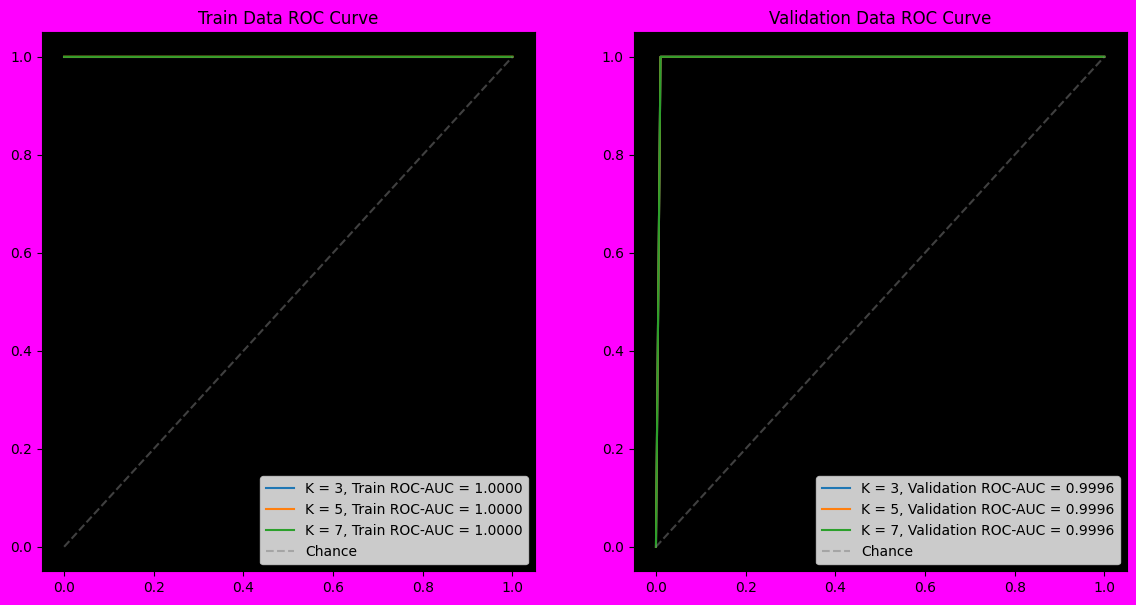

**********************************************************************************************************


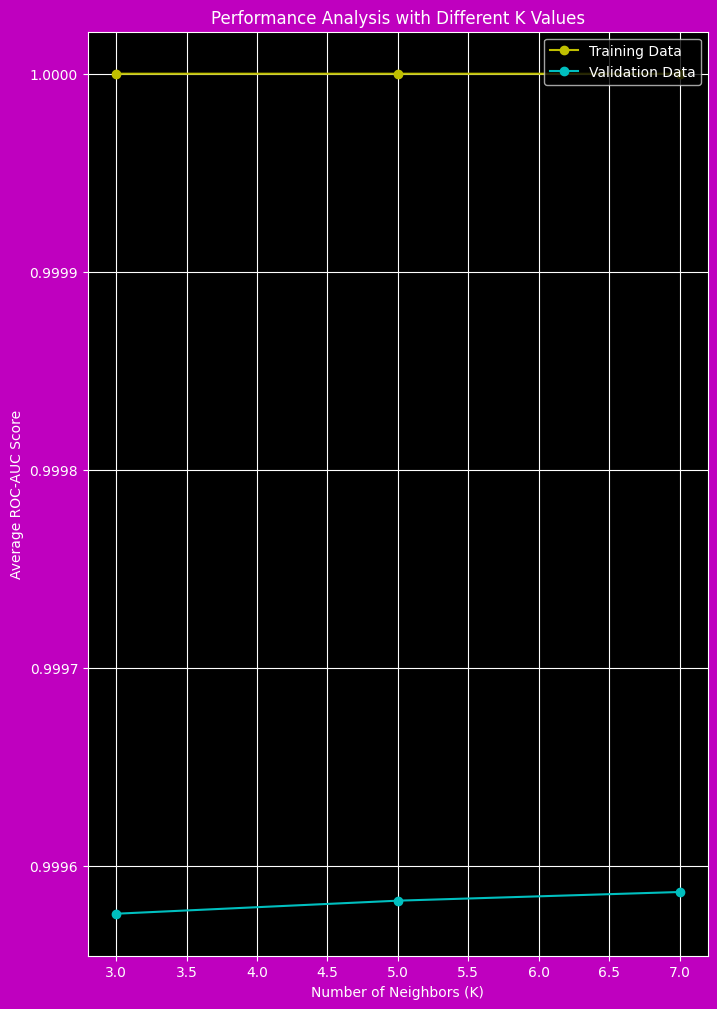

Summary of KNN Classifier's Performance:
ROC-AUC Scores for Training Data across different K values: 
 [1.0, 0.9999999962814559, 0.9999999899171641]
ROC-AUC Scores for Validation Data across different K values: 
 [0.999575729025911, 0.9995823239109177, 0.9995867020797528]
Optimal Number of Neighbors (K): 7
Best Average ROC-AUC Score for Validation Data: 0.9996
**********************************************************************************************************


In [15]:
print("**********************************************************************************************************")

print("Exploring KNN Classifier Performance:")

# List of considered 'K' values for KNN
neighbor_values = [3, 5, 7]

# Lists to capture mean scores for evaluation metrics
roc_auc_scores_train = []
roc_auc_scores_val = []
avg_fpr = np.linspace(0, 1, 100)

# Setting up subplots for visualizing ROC curves
fig, (train_plot, val_plot) = plt.subplots(1, 2, figsize=(14, 7), facecolor='fuchsia')
train_plot.set_facecolor('black')
val_plot.set_facecolor('black')

# Evaluating KNN performance for each 'K' value
for k in neighbor_values:
    print(f"Evaluating for K = {k} neighbors...")
    scores_train = []
    scores_val = []
    train_fpr_list = []
    train_tpr_list = []
    val_fpr_list = []
    val_tpr_list = []

    # Cross-validation loop
    for train_idx, val_idx in skf.split(X_smote_train_pt, y_smote_train_pt):
        start_time = time.time()
        print(f"Training Set: {train_idx}, Validation Set: {val_idx}")
        
        X_train_subset, X_val_subset = X_smote_train_pt[train_idx], X_smote_train_pt[val_idx]
        y_train_subset, y_val_subset = y_smote_train_pt.iloc[train_idx], y_smote_train_pt.iloc[val_idx]

        # Training the KNN classifier
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train_subset, y_train_subset)

        # Predictions and scoring for the training subset
        train_predictions = classifier.predict_proba(X_train_subset)
        train_auc = roc_auc_score(y_true=y_train_subset, y_score=train_predictions[:, 1])
        scores_train.append(train_auc)

        # Predictions and scoring for the validation subset
        val_predictions = classifier.predict_proba(X_val_subset)
        val_auc = roc_auc_score(y_true=y_val_subset, y_score=val_predictions[:, 1])
        scores_val.append(val_auc)

        train_fpr, train_tpr, _ = roc_curve(y_true=y_train_subset, y_score=train_predictions[:, 1])
        train_tpr_list.append(interp(avg_fpr, train_fpr, train_tpr))
        val_fpr, val_tpr, _ = roc_curve(y_true=y_val_subset, y_score=val_predictions[:, 1])
        val_tpr_list.append(interp(avg_fpr, val_fpr, val_tpr))
        
        time_spent = time.time() - start_time
        print(f"Time taken for this iteration: {time_spent:.2f} seconds")

    # Average performance metrics
    avg_roc_auc_train = np.mean(scores_train)
    roc_auc_scores_train.append(avg_roc_auc_train)
    avg_roc_auc_val = np.mean(scores_val)
    roc_auc_scores_val.append(avg_roc_auc_val)

    print(f"Average ROC-AUC - Training: {avg_roc_auc_train}, Validation: {avg_roc_auc_val}")
    print("------------------------------------------------------------------------------------------------------------")

    # Plotting the ROC curves
    train_plot.plot(avg_fpr, np.mean(train_tpr_list, axis=0), label=f"K = {k}, Train ROC-AUC = {avg_roc_auc_train:.4f}")
    val_plot.plot(avg_fpr, np.mean(val_tpr_list, axis=0), label=f"K = {k}, Validation ROC-AUC = {avg_roc_auc_val:.4f}")

print("Modeling with KNN Classifier is complete!")

print("Visualizing ROC-AUC Curves:")
train_plot.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance', alpha=0.5)
train_plot.set_title('Train Data ROC Curve')
val_plot.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance', alpha=0.5)
val_plot.set_title('Validation Data ROC Curve')

train_plot.legend(loc='lower right')
val_plot.legend(loc='lower right')
plt.show()

print("**********************************************************************************************************")

# Visualizing how ROC-AUC varies with 'K' values
with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 12), facecolor='m')
    plt.plot(neighbor_values, roc_auc_scores_train, 'yo-', label='Training Data')
    plt.plot(neighbor_values, roc_auc_scores_val, 'co-', label='Validation Data')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Average ROC-AUC Score')
    plt.title('Performance Analysis with Different K Values')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

print("Summary of KNN Classifier's Performance:")
print(f"ROC-AUC Scores for Training Data across different K values: \n {roc_auc_scores_train}")
print(f"ROC-AUC Scores for Validation Data across different K values: \n {roc_auc_scores_val}")
best_k_idx = np.argmax(roc_auc_scores_val)
print(f"Optimal Number of Neighbors (K): {neighbor_values[best_k_idx]}")
print(f"Best Average ROC-AUC Score for Validation Data: {roc_auc_scores_val[best_k_idx]:.4f}")

print("**********************************************************************************************************")


In [16]:
# Setting up KNN parameters for use in Stratified K-fold cross-validation
knn_parameters = {'n_neighbors': [9]}

# Initialize the KNN classifier
knn_model = KNeighborsClassifier()

start_timestamp = time.time()

# Setting up GridSearchCV for hyperparameter tuning with stratified cross-validation
grid_search_model = GridSearchCV(knn_model,
                                 param_grid=knn_parameters, 
                                 scoring='roc_auc', 
                                 cv=skf, 
                                 n_jobs=-1, # Utilizing all CPU cores
                                 verbose=1,
                                 # pre_dispatch=6, # This ensures memory consumption is kept in check
                                 return_train_score=True) 

# Train the model using GridSearchCV with the provided training data
grid_search_model.fit(X_smote_train_pt, y_smote_train_pt)

end_timestamp = time.time()
print("Duration: {:.2f} seconds".format(end_timestamp - start_timestamp))

# Display the chosen evaluation metric's result
print('Top ROC AUC score obtained: ', grid_search_model.best_score_)

# Display the optimal hyperparameters found
print('Optimal hyperparameters determined: ', grid_search_model.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Duration: 1002.48 seconds
Top ROC AUC score obtained:  0.999591073318903
Optimal hyperparameters determined:  {'n_neighbors': 9}


In [17]:
gridsearch_outcomes = grid_search_model.cv_results_

# Display the average test scores for each set of hyperparameters
print("Average test scores for each combination:")
for avg, hyperparams in zip(gridsearch_outcomes["mean_test_score"], gridsearch_outcomes["params"]):
    print(hyperparams, avg)

# Show the position of each set of hyperparameters based on their average test score
print("\nPosition based on test scores for each combination:")
for position, hyperparams in enumerate(gridsearch_outcomes["params"]):
    print(position+1, hyperparams)

# Indicate the test score variability for each hyperparameter set
print("\nVariability in test scores for each combination:")
for deviation, hyperparams in zip(gridsearch_outcomes["std_test_score"], gridsearch_outcomes["params"]):
    print(hyperparams, deviation)


Average test scores for each combination:
{'n_neighbors': 9} 0.999591073318903

Position based on test scores for each combination:
1 {'n_neighbors': 9}

Variability in test scores for each combination:
{'n_neighbors': 9} 3.535869384302741e-05
